## Wind/Wind Uncertainty from ERA-5

In [35]:
import json 
import matplotlib.pyplot as plt
import pandas as pd

In [61]:
with open('/scratch/colemanr/emit-ghg/logging/ime_q_w_source_20231030.txt') as f: 
    lines = f.readlines()
    lines = [line.strip().split("\n") for line in lines]

    # Create a dictionary to store the data
    data_dict = {}
    current_key = None

    # Store the data in the dictionary
    for line in lines:
        line = line[0].split(": ")
        if len(line) == 2:
            key, value = line
            data_dict.setdefault(key, []).append(value)
            current_key = key
        else:
            data_dict[current_key][-1] += " " + line[0]

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(data_dict)
df

,Plume ID,Threshold,Plume Area,Max IME,Max Q,Avg Windspeed,Windspeed Unc
0,CH4_PlumeComplex-257,2957.9149699640698,614,661.168107488606,2533.393956881834,3.0123577,0.2599814
1,CH4_PlumeComplex-258,0,765,448.24003571641254,914.8026291813611,2.11516,0.16443813
2,CH4_PlumeComplex-260,0,1852,3277.2356292580553,13906.82837457135,3.6485639,0.3587307
3,CH4_PlumeComplex-311,0,154,130.7222741293624,2193.86052389924,5.456052,0.4702225
4,CH4_PlumeComplex-314,0,1768,1415.5833437241135,4039.606963160518,4.4455137,0.45792535
...,...,...,...,...,...,...,...
159,CH4_PlumeComplex-1449,0,1315,892.7495435832227,1041.423437713366,1.6575605,0.26521456
160,CH4_PlumeComplex-1450,0,588,473.1436043387089,1296.483947202693,1.6575605,0.26521456
161,CH4_PlumeComplex-1451,0,181,155.82518231726297,1381.2461626789932,1.6575605,0.26521456
162,CH4_PlumeComplex-1452,0,558,394.357417406374,1541.9969272535852,1.6575605,0.26521456


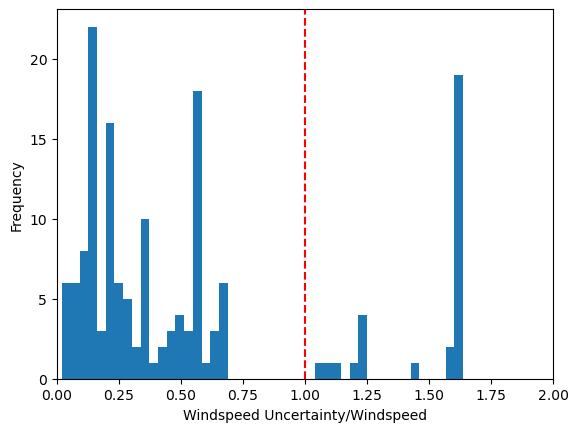

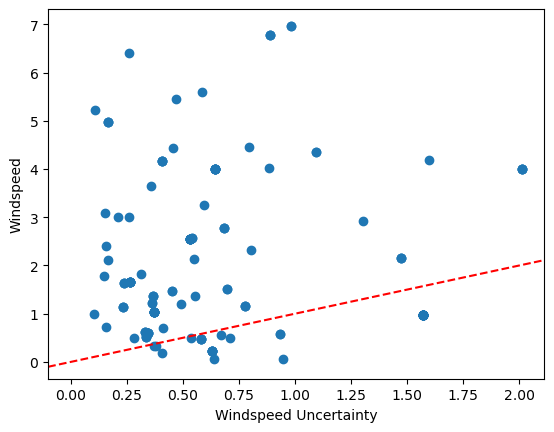

In [62]:
df['Windspeed Unc'] = pd.to_numeric(df['Windspeed Unc'])
df['Avg Windspeed'] = pd.to_numeric(df['Avg Windspeed'])

plt.hist(df['Windspeed Unc']/df['Avg Windspeed'], bins = 500)
plt.xlim([0, 2])
plt.axvline(1, color = 'red', linestyle = 'dashed')
plt.xlabel('Windspeed Uncertainty/Windspeed')
plt.ylabel('Frequency')
plt.show()

plt.scatter(df['Windspeed Unc'], df['Avg Windspeed'])
plt.xlabel('Windspeed Uncertainty')
plt.ylabel('Windspeed')
plt.axline((0, 0), slope=1, color = 'red', linestyle = 'dashed')
plt.show()

## Creating .xlsx file for running compute_ime_CNNbypass

In [1]:
import pandas as pd
import simplejson as json

In [10]:
##########################################
# Path to delineated plume COGs
plume_path = '/scratch/brodrick/methane/visions_delivery/'

# Path to plume metadata (.json) 
metadata_path = '/scratch/brodrick/methane/visions_delivery/combined_plume_metadata.json'

# Open plume metadata as nested json dict
with open(metadata_path, 'r') as f: 
    metadata = json.loads(f.read())
plume_df = pd.json_normalize(metadata['features'])

# Open manual plume annotation for source pixels
metadata_path_annotation = '/scratch/brodrick/methane/ch4_plumedir/previous_manual_annotation_oneback.json'
with open(metadata_path_annotation, 'r') as f: 
    meta = json.loads(f.read())
meta_df = pd.json_normalize(meta['features'])

# Join meta_df (properties.name) and plume_df (properties.Plume ID) 
merge_df = pd.merge(plume_df, meta_df, left_on = 'properties.Plume ID', right_on = 'properties.Plume ID')

# Remove duplicate plume metadata "Point" entries 
poly_df = merge_df[merge_df['geometry.type_x'] == 'Polygon']
plume_id_list = list(poly_df['properties.Plume ID'])
scene_fid_list = list(poly_df['properties.Scene FIDs'])
pseudo_o_list = list(poly_df['properties.Psuedo-Origin'])
uncertainty_list = list(poly_df['properties.Concentration Uncertainty (ppm m)'])

## REPLACE with ID list from Clayton 
non_empty_indices = [index for index, string in enumerate(list(poly_df['properties.Psuedo-Origin'])) if string]
non_empty_ids = [list(poly_df['properties.Plume ID'])[i] for i in non_empty_indices]

In [29]:
## Create .xlsx file for running compute_IME

lats, lons, plume_ids, fids = [], [], [], []
for i in non_empty_indices:     
    
    # Check for broken pseudo-origin metadata
    try:
        pseudo_o = json.loads(pseudo_o_list[i])
    except Exception as e:        
        print(plume_id)
        pass
    
    fid = scene_fid_list[i]
    plume_id = plume_id_list[i]
    coords = pseudo_o["coordinates"]
    plume_lat = coords[1]
    plume_lon = coords[0]

    if len(fid) > 1: 
        for f in fid: 
            lats.append(plume_lat)
            lons.append(plume_lon)
            plume_ids.append(plume_id)
            fids.append(f) 
    else: 
        lats.append(plume_lat)
        lons.append(plume_lon)
        plume_ids.append(plume_id)
        fids.append(fid[0])

    plume_df = pd.DataFrame(
        {'Plume Latitude (deg)': lats, 
         'Plume Longitude (deg)': lons, 
         'Candidate ID': plume_ids, 
         'Line name': fids, 
        })

    plume_df['CMF Min (ppmm)'] = ""
    plume_df['CMF Max (ppmm)'] = ""
    plume_df['CMF Median (ppmm)'] = ""
    plume_df['CMF MAD (ppmm)'] = ""
    plume_df['Salience Min (%)'] = ""
    plume_df['Salience Max (%)'] = ""
    plume_df['Salience Median (%)'] = ""
    plume_df['Salience MAD (%)'] = ""
    plume_df['Cloud'] = ""
    plume_df['Specular'] = ""
    plume_df['Flare'] = ""
    plume_df['Dark'] = ""

CH4_PlumeComplex-1526
CH4_PlumeComplex-1529


In [42]:
out_df = plume_df.sample(n=10)
out_df.to_excel('/scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/EMIT_plume_test.xlsx')
out_df.to_csv('/scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/EMIT_plume_test.csv')

## UTM -> LatLon Conversion 

In [34]:
from LatLongUTMconversion import LLtoUTM
import os
from spectral.io import envi
from emit_utils.file_checks import envi_header
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
import pandas as pd
import pyproj
from pyproj import CRS

In [43]:
plume_info_path = '/scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/EMIT_plume_test.csv'
plume_info = pd.read_csv(plume_info_path)

refEll = 23 # WGS-84
acq_path = '/beegfs/scratch/brodrick/methane/methane_20230813/'
reproj_path = '/beegfs/scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/reproj/'

# Reproject into UTM zone 
for i in range(len(plume_info)): 
    Lat = plume_info['Plume Latitude (deg)'][i]
    Long = plume_info['Plume Longitude (deg)'][i]
    fid = plume_info['Line name'][i]
    
    utm_zone,_,_ = LLtoUTM(refEll, Lat, Long)
    utm_zone_string = f"+proj=utm +zone={utm_zone[:-1]} +ellps=WGS84"
    epsg_code = CRS.from_string(utm_zone_string).to_epsg()
    dstSRS = 'EPSG:' + str(epsg_code)
    
    in_path = os.path.join(acq_path, fid[4:12], fid + '_ch4_mf_ort')
    out_path = os.path.join(reproj_path, fid + '_ch4_mf_ort_utm')
        
    command = f"gdalwarp -r near -t_srs {dstSRS} {in_path} {out_path} -of ENVI"
    os.system(command)

29.64800385 6.96224213 emit20230730t122047
Creating output file that is 2124P x 2070L.
Processing /beegfs/scratch/brodrick/methane/methane_20230813/20230730/emit20230730t122047_ch4_mf_ort [1/1] : 0Using internal nodata values (e.g. -9999) for image /beegfs/scratch/brodrick/methane/methane_20230813/20230730/emit20230730t122047_ch4_mf_ort.
Copying nodata values from source /beegfs/scratch/brodrick/methane/methane_20230813/20230730/emit20230730t122047_ch4_mf_ort to destination /beegfs/scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/reproj/emit20230730t122047_ch4_mf_ort_utm.
...10...20...30...40...50...60...70...80...90...100 - done.
30.16835858 50.41019467 emit20230629t061650
Creating output file that is 2588P x 2840L.
Processing /beegfs/scratch/brodrick/methane/methane_20230813/20230629/emit20230629t061650_ch4_mf_ort [1/1] : 0Using internal nodata values (e.g. -9999) for image /beegfs/scratch/brodrick/methane/methane_20230813/20230629/emit20230629t061650_ch4_mf_ort.
Copying nodat

ERROR 1: Output dataset /beegfs/scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/reproj/emit20230629t061650_ch4_mf_ort_utm exists,
but some command line options were provided indicating a new dataset
should be created.  Please delete existing dataset and run again.



34.86524496 38.85881442 emit20230807t073622
Creating output file that is 2185P x 2118L.
Processing /beegfs/scratch/brodrick/methane/methane_20230813/20230807/emit20230807t073622_ch4_mf_ort [1/1] : 0Using internal nodata values (e.g. -9999) for image /beegfs/scratch/brodrick/methane/methane_20230813/20230807/emit20230807t073622_ch4_mf_ort.
Copying nodata values from source /beegfs/scratch/brodrick/methane/methane_20230813/20230807/emit20230807t073622_ch4_mf_ort to destination /beegfs/scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/reproj/emit20230807t073622_ch4_mf_ort_utm.
...10...20...30...40...50...60...70...80...90...100 - done.
38.55568324 62.76420593 emit20231003t074704
Creating output file that is 2245P x 2163L.
Processing /beegfs/scratch/brodrick/methane/methane_20230813/20231003/emit20231003t074704_ch4_mf_ort [1/1] : 0Using internal nodata values (e.g. -9999) for image /beegfs/scratch/brodrick/methane/methane_20230813/20231003/emit20231003t074704_ch4_mf_ort.
Copying noda

In [45]:
# python compute_ime_CNN_rwc.py --clobber --cmfdir /scratch/colemanr/emit-ghg/reproj/  --calids v2x1 --cmfsuf *ch4*_utm --ppmmthr 500 --ppmmmax 3000 --fetchmax 1000 --mergedists 200 --minarea 9 --outdir /scratch/colemanr/emit-ghg/ime_20231101/ /scratch/colemanr/emit-ghg/EMIT_plume_ime.xlsx Sheet1

python compute_ime_CNN_rwc.py --clobber --cmfdir /scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/reproj/  --calids v2x1 --cmfsuf *ch4*_utm --ppmmthr 500 --ppmmmax 3000 --fetchmax 1000 --mergedists 200 --minarea 9 --outdir /scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/out/ /scratch/colemanr/emit-ghg/ime_2024_manuscript/cm_figure/EMIT_plume_test.xlsx Sheet1


,Unnamed: 0,Plume Latitude (deg),Plume Longitude (deg),Candidate ID,Line name,CMF Min (ppmm),CMF Max (ppmm),CMF Median (ppmm),CMF MAD (ppmm),Salience Min (%),Salience Max (%),Salience Median (%),Salience MAD (%),Cloud,Specular,Flare,Dark
0,163,29.648004,6.962242,CH4_PlumeComplex-364,emit20230730t122047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,143,30.168359,50.410195,CH4_PlumeComplex-105,emit20230629t061650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,96,37.952838,-120.954772,CH4_PlumeComplex-325,emit20230622t193213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,444,31.322141,-103.061880,CH4_PlumeComplex-1892,emit20231028t161900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,142,30.760937,49.983366,CH4_PlumeComplex-102,emit20230629t061650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,275,34.865245,38.858814,CH4_PlumeComplex-1205,emit20230807t073622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,356,38.555683,62.764206,CH4_PlumeComplex-1597,emit20231003t074704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,373,33.485433,3.305039,CH4_PlumeComplex-1584,emit20231006t100206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,551,26.319810,67.445326,CH4_PlumeComplex-2436,emit20230606t053448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,290,35.462208,51.325979,CH4_PlumeComplex-1436,emit20230924t114413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
## Recursively go through all folders in ime_20231101 and stack csv files together into a singel dataframe 
def concatenate_csvs_in_directory(root_dir):
    all_dataframes = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.csv'):
                file_path = os.path.join(subdir, file)
                df = pd.read_csv(file_path)
                all_dataframes.append(df)

    if all_dataframes:
        concatenated_df = pd.concat(all_dataframes, ignore_index=True)
        return concatenated_df
    else:
        return None

# Replace 'your_directory_path' with the path to your root directory containing CSV files
root_directory_path = '/scratch/colemanr/emit-ghg/ime_20231101'
result_df = concatenate_csvs_in_directory(root_directory_path)

if result_df is None:
    print("No CSV files found in the directory.")

result_df.to_csv('EMIT_plume_ime_CNN.csv')

In [14]:
result_df
# result_df[' Candidate ID'][0]

,# Line name,Candidate ID,Plume Latitude (deg),Plume Longitude (deg),CMF Min (ppmm),CMF Max (ppmm),CMF Median (ppmm),CMF MAD (ppmm),Salience Min (%),Salience Max (%),...,IME200 (kg),Fetch200 (m),DetId200,Aspect ratio200,Total pixels200,AvgIME200 (kg/m),AvgFetch200 (kg/m),AvgIMEdivFetch200 (kg/m),StdIMEdivFetch200 (kg/m),CMF max200 (ppmm)
0,emit20230817t105803,CH4_PlumeComplex-1183,35.348806,40.370851,nan,nan,nan,nan,nan,nan,...,271.221021,962.905959,1535,0.107223,165.0,124.386406,12.500000,0.173307,0.026689,1850.5450
1,emit20230817t105803,CH4_PlumeComplex-1185,35.305144,40.442964,nan,nan,nan,nan,nan,nan,...,238.873331,962.905959,1535,0.105308,168.0,111.750986,12.500000,0.154691,0.027846,3281.2290
2,emit20230817t105803,CH4_PlumeComplex-1186,35.298462,40.425047,nan,nan,nan,nan,nan,nan,...,126.178207,962.905959,1535,0.213154,83.0,68.658116,12.500000,0.102155,0.017230,1989.7722
3,emit20230817t105803,CH4_PlumeComplex-1187,35.381743,40.438934,nan,nan,nan,nan,nan,nan,...,101.799354,962.905959,1535,0.223947,79.0,51.881955,12.869565,0.068394,0.014133,1045.5287
4,emit20231004t174732,CH4_PlumeComplex-1454,32.082370,-104.484664,nan,nan,nan,nan,nan,nan,...,428.645108,800.134751,1,0.052001,280.0,231.051277,11.000000,0.363470,0.044894,2306.1130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,emit20230616t211419,CH4_PlumeComplex-1063,31.568469,-101.916647,nan,nan,nan,nan,nan,nan,...,90.882343,915.824121,1,0.252326,65.0,54.078110,12.000000,0.091497,0.023358,1367.4763
240,emit20230602t071917,CH4_PlumeComplex-321,42.014670,86.552214,nan,nan,nan,nan,nan,nan,...,326.062935,834.871040,1,0.084577,195.0,206.432745,12.500000,0.309236,0.085916,3148.6946
241,emit20230823t092349,CH4_PlumeComplex-1011,31.319337,34.746199,nan,nan,nan,nan,nan,nan,...,554.121230,851.843503,3,0.050377,303.0,314.312986,11.500000,0.432398,0.138371,1949.3108
242,emit20230823t170609,CH4_PlumeComplex-1002,36.403079,-89.154229,nan,nan,nan,nan,nan,nan,...,999.722736,962.190440,9,0.035635,502.0,563.740522,12.500000,0.824337,0.104438,5482.9400
